## Gather all results and then identify one best combination per dataset, per algorithm. 

This notebook gathers all of the results produced by Snakemake, create big dataframe with all of the results and then finds the best hyper-parameter combination, per dataset, per clustering. The output from this notebook will be dataframe consisting all of the combinations produced by Snakemake (benchmark_analysis/metrics folder), and then dataframe with the best hyper-parameter combination per dataset, per algorithm (best similairty measure, best graph type, best k number of neighbors, best quality function and best resolution.)

In [1]:
import sys
sys.path.append("../workflow") 
sys.path.append("../workflow/scripts")
sys.path.append("../results_analysis/")
METRIC = 'PCA_score'
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import yaml
#import scanpy as sc
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import StandardScaler
from parse_config import *
import numpy as np
from sklearn.decomposition import PCA
configfile = "../config.yaml"

with open(configfile, "r") as f:
    config = yaml.safe_load(f)  # Load YAML config into a dictionary

cfg = PrepConfig(config)  # Now use PrepConfig

### Define functions

In [2]:
def match_rows(df1_row, df2, columns_to_match):
    """
    Find rows in df2 that match a given row from df1 based on specified columns.
    
    Parameters:
    - df1_row (pd.Series): A row from df1.
    - df2 (pd.DataFrame): The DataFrame to search in.
    - columns_to_match (list): List of column names to match.
    
    Returns:
    - pd.DataFrame: Matching rows from df2.
    """
    return df2[df2[columns_to_match].eq(df1_row[columns_to_match]).all(axis=1)]


In [3]:
def process_results(results_dir):
    """Processes all result files in the given directory and compiles them into a DataFrame."""
    
    dfs = []

    for root, _, files in os.walk(results_dir):
        for file in files:
            if file.endswith(".txt"):  
                file_path = os.path.join(root, file)
                try:
                    df = pd.read_csv(file_path, sep=",")
                    
                    required_columns = {'psi', 'ar', 'nmi'}
                    if not required_columns.issubset(df.columns):
                        print(f"Skipping {file}: Missing required evaluation metrics.")
                        continue

                    psi_col = df['psi']
                    ari_col = df['ar']
                    nmi_col = df['nmi']

                    path_parts = root.split(os.sep)
                    if len(path_parts) < 4:
                        print(f"Skipping {file}: Invalid directory structure.")
                        continue

                    dataset, algorithm_clust, graph_con, similarity_metric = path_parts[-4:]

                    k_value = file.split('.')[0].split('k')[0]
                    
                    if df.shape[1] > 0:
                        quality_fun = df.iloc[:, 0].str.split('_').str[0]
                        resolution = df.iloc[:, 0].str.split('_').str[1]
                    else:
                        print(f"Skipping {file}: Empty DataFrame.")
                        continue

                    df_extracted = pd.DataFrame({
                        'Dataset': dataset,
                        'Clustering_algorithm': algorithm_clust,
                        'Similarity_Measure': similarity_metric,
                        'K_Neighbors': k_value.split('n')[0],
                        'Quality_Function': quality_fun,
                        'Graph_type': graph_con,
                        'Resolution': resolution,
                        'ARI': ari_col,
                        'PSI': psi_col,
                        'NMI': nmi_col
                    })

                    dfs.append(df_extracted)

                except Exception as e:
                    print(f"Error processing {file}: {e}")

    if dfs:
        results_df = pd.concat(dfs, ignore_index=True)
        return results_df
    else:
        print("No valid result files found.")
        return pd.DataFrame()  


In [36]:
all_results = process_results("../results/benchmark_analysis/evaluation/")

In [37]:
all_results.to_pickle("../results_analysis/benchmark_all_results.pkl")

## Find linear combination of all of the evaluation measures using PCA

In [8]:
eval_metrics = all_results.iloc[:,-3:]

In [9]:
eval_metrics

,ARI,PSI,NMI
0,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000
...,...,...,...
34911655,0.481244,0.147496,0.659752
34911656,0.481078,0.148432,0.660234
34911657,0.480874,0.143781,0.659219
34911658,0.480596,0.143494,0.659032


In [75]:
def calculate_pca(data, n_comp, scale=False):
    if (scale==True):
        scaler = StandardScaler()
        data = scaler.fit_transform(data)
  
    pca = PCA(n_components=n_comp)
    X_reduced = pca.fit_transform(data)
    loadings = pca.components_.T
    ex_variance =pca.explained_variance_ratio_
    return X_reduced, loadings, ex_variance


In [76]:
pca_raw, loadings_raw, var_raw = calculate_pca(eval_metrics, 2, scale=False)

In [ ]:

fig, ax = plt.subplots(figsize=(7, 6))

for i, feature in enumerate(eval_metrics.columns):
    ax.arrow(0, 0, loadings_raw[i, 0], loadings_raw[i, 1],
             color='r', alpha=0.5, head_width=0.05)
    # Scale back text position to stay inside plot borders
    ax.text(loadings_raw[i, 0] * 1.05, loadings_raw[i, 1] * 1.05,
            feature, color='g', ha='center', va='center')

ax.set_xlabel(f'PC1 ({var_raw[0]*100:.1f}% var)')
ax.set_ylabel(f'PC2 ({var_raw[1]*100:.1f}% var)')
ax.set_title('PCA Loadings')
ax.grid()
ax.axhline(0, color='black', lw=1)
ax.axvline(0, color='black', lw=1)

plt.tight_layout()
plt.savefig("pca_raw_loadings.eps", format='eps')
plt.show()

In [77]:
all_results['PCA_score'] = pca_raw[:,0]

In [ ]:
all_results.to_pickle("../results_analysis/benchmark_all_results_pca_score.pkl")

### For the analysis in this notebook, if you wish to reproduce paper results load benchmark_paper_all_results.pkl dataframe 

In [2]:
all_results = pd.read_pickle("../results_analysis/paper_reproduce/benchmark_paper_all_results.pkl")

## Identifying best combinations in terms of evaluation score per Dataset per Clustering algorithm


In [78]:
max_metric_per_group = all_results.groupby(['Dataset', 'Clustering_algorithm'])[METRIC].idxmax()

In [79]:
best_metric = all_results.loc[max_metric_per_group].reset_index(drop=True)

There is usually more hyper-parameter combinations that have the same score value

In [80]:
same_best_metric = pd.merge(best_metric[['Dataset', 'Clustering_algorithm', METRIC]], all_results, how='left')

Reorder columns

In [81]:
same_best_metric = same_best_metric[['Dataset', 'Clustering_algorithm', 'Similarity_Measure',
       'K_Neighbors', 'Quality_Function', 'Graph_type', 'Resolution', 'ARI',
       'PSI', 'NMI',  'PCA_score']]

In [82]:
for group_idx, group_df in same_best_metric.groupby(['Dataset', 'Clustering_algorithm']):
    print(f"Found {len(group_df)} best combinations with regard to {METRIC} for {group_idx[0]}, for {group_idx[1]}")

Found 1 best combinations with regard to PSI for BaronPancreasData, for leiden
Found 4 best combinations with regard to PSI for BaronPancreasData, for louvain
Found 46711 best combinations with regard to PSI for Biase, for leiden
Found 47239 best combinations with regard to PSI for Biase, for louvain
Found 3 best combinations with regard to PSI for DarmanisBrainData, for leiden
Found 1 best combinations with regard to PSI for DarmanisBrainData, for louvain
Found 639 best combinations with regard to PSI for Deng, for leiden
Found 756 best combinations with regard to PSI for Deng, for louvain
Found 115 best combinations with regard to PSI for Goolam, for leiden
Found 120 best combinations with regard to PSI for Goolam, for louvain
Found 2 best combinations with regard to PSI for Jung, for leiden
Found 2 best combinations with regard to PSI for Jung, for louvain
Found 8 best combinations with regard to PSI for Koh, for leiden
Found 1 best combinations with regard to PSI for Koh, for louva

In [83]:
same_best_metric

,Dataset,Clustering_algorithm,Similarity_Measure,K_Neighbors,Quality_Function,Graph_type,Resolution,ARI,PSI,NMI,PCA_score
0,BaronPancreasData,leiden,cosine,3,RBConfigurationVertexPartition,jaccard_seurat,0.661,0.126146,0.191503,0.483615,-0.264448
1,BaronPancreasData,louvain,cosine,3,RBConfigurationVertexPartition,jaccard_seurat,0.721,0.124563,0.192418,0.482959,-0.265358
2,BaronPancreasData,louvain,cosine,3,RBConfigurationVertexPartition,jaccard_seurat,0.741,0.124563,0.192418,0.482959,-0.265358
3,BaronPancreasData,louvain,cosine,3,RBConfigurationVertexPartition,jaccard_seurat,0.761,0.124563,0.192418,0.482959,-0.265358
4,BaronPancreasData,louvain,cosine,3,RBConfigurationVertexPartition,jaccard_seurat,0.781,0.124563,0.192418,0.482959,-0.265358
...,...,...,...,...,...,...,...,...,...,...,...
525526,Zheng,louvain,braycurtis,34,RBConfigurationVertexPartition,jaccard_phenograph,0.381,0.453151,0.316612,0.588732,0.080056
525527,Zheng,louvain,braycurtis,34,RBConfigurationVertexPartition,jaccard_phenograph,0.401,0.453151,0.316612,0.588732,0.080056
525528,Zheng,louvain,braycurtis,34,RBConfigurationVertexPartition,jaccard_phenograph,0.421,0.453151,0.316612,0.588732,0.080056
525529,Zheng,louvain,braycurtis,34,RBConfigurationVertexPartition,jaccard_phenograph,0.441,0.453151,0.316612,0.588732,0.080056


### First tie-solving rule - robustness of optimal hyper-parameter combination performance to changes in resolution

#### Optimal performance + robustness (resolution)

Check for each dataset for each different combination for how many resolution values the best score value was maintained.\
The particular combination will be better if it was able to get the "peak" score for more resolution values (it's more robust).


In [84]:
group_cols = ['Dataset', 'Clustering_algorithm', 'Quality_Function',
               'Similarity_Measure', 'K_Neighbors', 'Graph_type','PCA_score', 'ARI','NMI','PSI']

# For each combination of columns with the same evaluation scores, check for how many Resolution values (that's 
# why we don't group by resolution) the best, same score value was obtained
df_max_res_range = (
    same_best_metric.groupby(group_cols)
    .size()
    .reset_index(name='Max_across_res_values')
)

# Calculate the median K_Neighbors per group if there is a range of values keeping the same combination
median_res = (
    same_best_metric.groupby(group_cols)['Resolution']
    .apply(lambda x: x.dropna().sort_values().iloc[len(x)//2] if len(x) else None)
    .reset_index(name='Resolution')
)

# Merge the median K_Neighbors back to the df_max_k_range
df_max_res_range = df_max_res_range.merge(median_res, on=group_cols, how='left')


In [85]:
df_max_res_range

,Dataset,Clustering_algorithm,Quality_Function,Similarity_Measure,K_Neighbors,Graph_type,PCA_score,ARI,NMI,PSI,Max_across_res_values,Resolution
0,BaronPancreasData,leiden,RBConfigurationVertexPartition,cosine,3,jaccard_seurat,-0.264448,0.126146,0.483615,0.191503,1,0.661
1,BaronPancreasData,louvain,RBConfigurationVertexPartition,cosine,3,jaccard_seurat,-0.265358,0.124563,0.482959,0.192418,4,0.761
2,Biase,leiden,CPMVertexPartition,braycurtis,10,gauss,1.025212,1.000000,1.000000,1.000000,21,0.261
3,Biase,leiden,CPMVertexPartition,braycurtis,10,jaccard_phenograph,1.025212,1.000000,1.000000,1.000000,1,0.021
4,Biase,leiden,CPMVertexPartition,braycurtis,10,jaccard_seurat,1.025212,1.000000,1.000000,1.000000,9,0.221
...,...,...,...,...,...,...,...,...,...,...,...,...
17862,Yan,louvain,RBERVertexPartition,rho,44,jaccard_seurat,0.665699,0.832585,0.861249,0.672870,1,1.861
17863,ZeiselBrainData,leiden,RBERVertexPartition,cosine,7,jaccard_seurat,0.082035,0.447513,0.598634,0.318835,1,0.341
17864,ZeiselBrainData,louvain,RBERVertexPartition,cosine,7,jaccard_seurat,0.082975,0.447582,0.599101,0.320071,1,0.341
17865,Zheng,leiden,RBConfigurationVertexPartition,braycurtis,51,jaccard_phenograph,0.081728,0.455737,0.588566,0.316534,1,0.461


Again, there is more than one keeping this best combination for a range of values. Get all combinations keeping the same, maximum range 

In [86]:
idx = df_max_res_range.groupby(['Dataset','Clustering_algorithm'])['Max_across_res_values'].transform('max') == df_max_res_range['Max_across_res_values']

In [87]:
best_res= df_max_res_range[idx]

In [88]:
for group_idx, group_df in best_res.groupby(['Dataset', 'Clustering_algorithm']):
    if (len(group_df)>1):
        print(f"Found {len(group_df)} best combinations with regard to {METRIC} for {group_idx[0]}, for {group_idx[1]}")

Found 2 best combinations with regard to PSI for Deng, for leiden
Found 2 best combinations with regard to PSI for Jung, for leiden
Found 2 best combinations with regard to PSI for Jung, for louvain
Found 8 best combinations with regard to PSI for Koh, for leiden
Found 4 best combinations with regard to PSI for Kolodziejczyk, for leiden
Found 4 best combinations with regard to PSI for Kolodziejczyk, for louvain
Found 2 best combinations with regard to PSI for RomanovBrainData, for leiden
Found 2 best combinations with regard to PSI for RomanovBrainData, for louvain
Found 4 best combinations with regard to PSI for Yan, for leiden
Found 6 best combinations with regard to PSI for Yan, for louvain


Extract datasets that have more than one row for the combination of Dataset and Algorithm

In [89]:
value_counts = best_res.value_counts(subset=['Dataset', 'Clustering_algorithm'])
filtered_pairs = value_counts[value_counts >= 2].index  # Extract dataset-algorithm pairs
filtered_pairs

MultiIndex([(             'Koh',  'leiden'),
            (             'Yan', 'louvain'),
            (   'Kolodziejczyk', 'louvain'),
            (   'Kolodziejczyk',  'leiden'),
            (             'Yan',  'leiden'),
            ('RomanovBrainData', 'louvain'),
            (            'Jung', 'louvain'),
            ('RomanovBrainData',  'leiden'),
            (            'Deng',  'leiden'),
            (            'Jung',  'leiden')],
           names=['Dataset', 'Clustering_algorithm'])

In [90]:
datasets_no_ties = best_res[~best_res[['Dataset', 'Clustering_algorithm']].apply(tuple, axis=1).isin(filtered_pairs)]
datasets_ties = best_res[best_res[['Dataset', 'Clustering_algorithm']].apply(tuple, axis=1).isin(filtered_pairs)].reset_index()

### Second tie-solving rule - mean hyper-parameter combination performance over range of resolution values

In [91]:
match_cols = ['Dataset', 'Clustering_algorithm', 'K_Neighbors', 'Graph_type',
               'Quality_Function', 'Similarity_Measure']

# 2. Merge datasets_ties with all_results on these columns
merged = pd.merge(datasets_ties, all_results, on=match_cols, how='left')
merged['row_idx'] = merged['index']
mean_metric_res = merged.groupby('row_idx')[f"{METRIC}_y"].mean().reset_index(drop=True)


In [92]:
datasets_ties[f'Mean_{METRIC}'] = mean_metric_res

In [93]:
max_metric_df = datasets_ties.groupby(['Dataset', 'Clustering_algorithm'])[f'Mean_{METRIC}'].transform('max')
datasets_ties_resolved = datasets_ties[datasets_ties[f'Mean_{METRIC}'] == max_metric_df]

There are still some ties within these:

In [94]:
combinations_to_check = []
for group, comb in datasets_ties_resolved.groupby(['Dataset', 'Clustering_algorithm']):
    if (len(comb)>1):
        combinations_to_check.append(comb)
        print(f"Found {len(comb)} best combinations with regard to mean {METRIC} for {group[0]}, for {group[1]}")

Found 2 best combinations with regard to mean PSI for Jung, for leiden
Found 2 best combinations with regard to mean PSI for Jung, for louvain
Found 2 best combinations with regard to mean PSI for Kolodziejczyk, for leiden
Found 2 best combinations with regard to mean PSI for Kolodziejczyk, for louvain
Found 2 best combinations with regard to mean PSI for RomanovBrainData, for leiden
Found 2 best combinations with regard to mean PSI for RomanovBrainData, for louvain
Found 2 best combinations with regard to mean PSI for Yan, for leiden
Found 2 best combinations with regard to mean PSI for Yan, for louvain


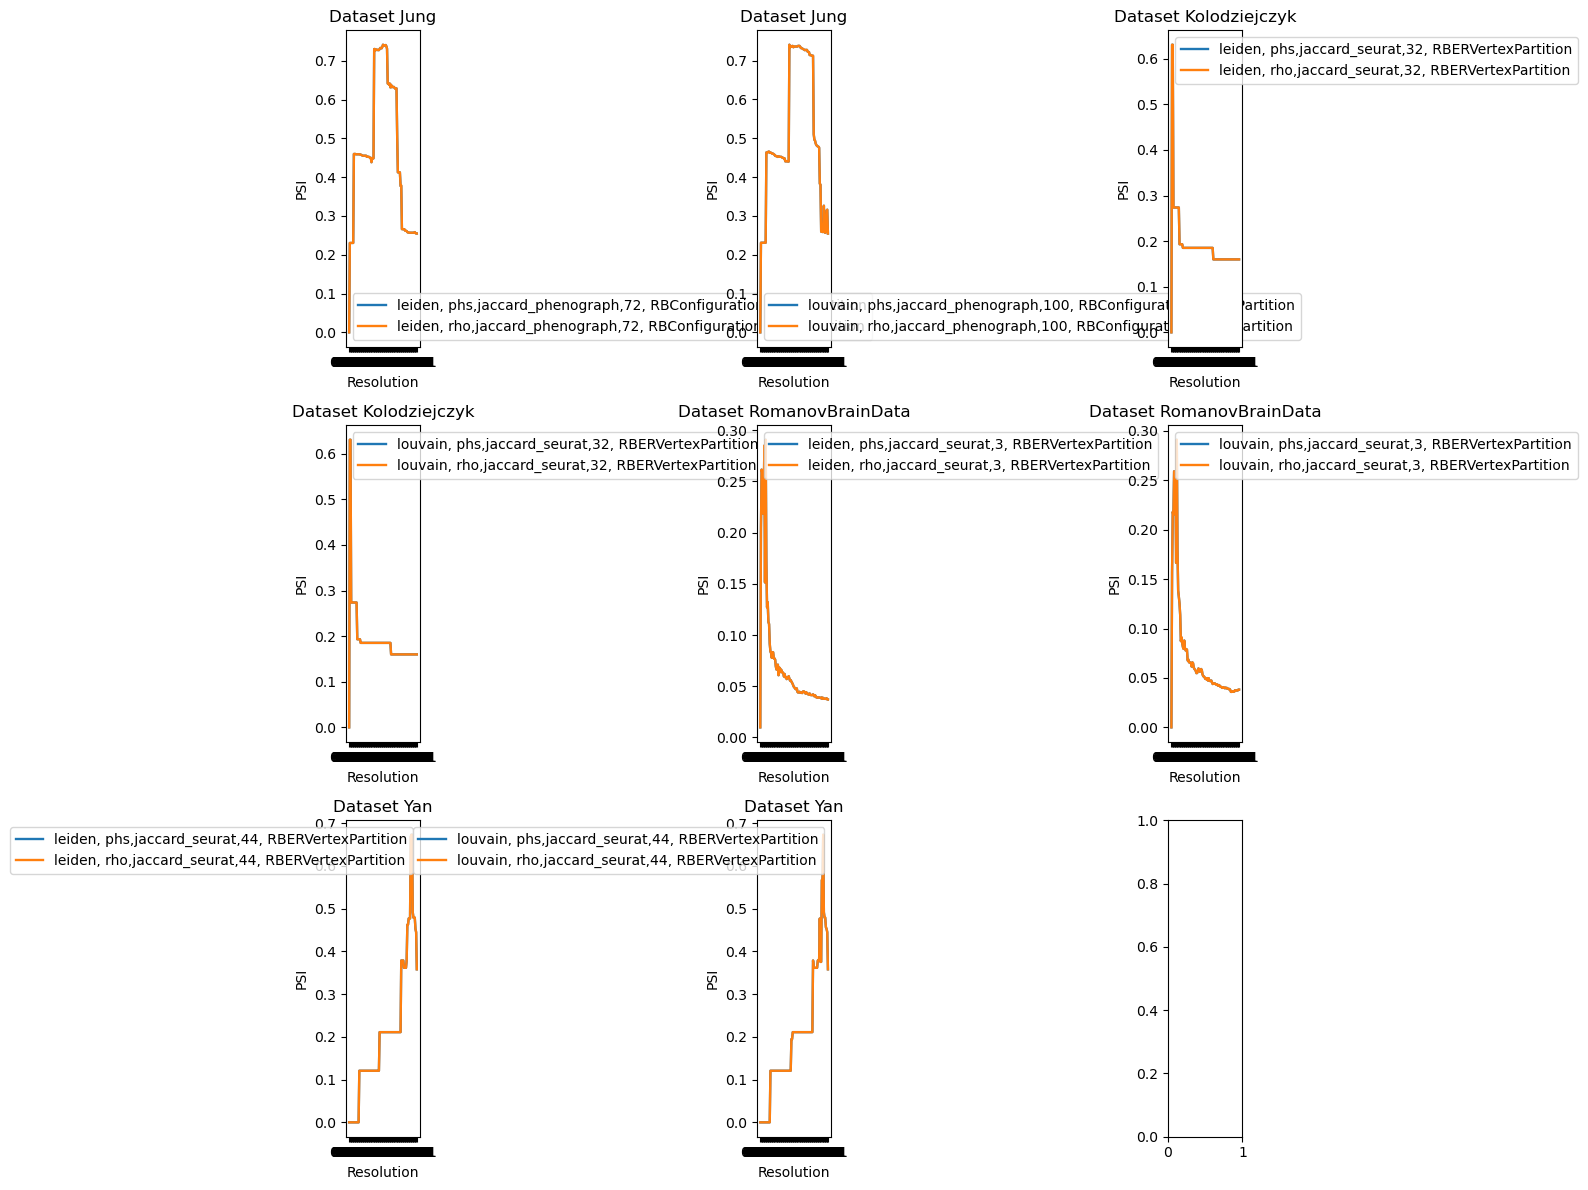

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
checks = []
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()  # Flatten for easy iteration

i = 0  # Move 'i' outside the loop

for comb in combinations_to_check:
    for idx, row in comb.iterrows():
        if i >= len(axes):  # Prevent index error if too many combinations
            break

        # Find matching rows
        matches = match_rows(row, all_results, [
            'Dataset', 'Quality_Function', 'Similarity_Measure',
            'K_Neighbors', 'Graph_type', 'Clustering_algorithm'
        ])

        checks.append(matches)
        # Plot lineplot
        sns.lineplot(x="Resolution", y=f"{METRIC}", data=matches, ax=axes[i], 
                     linewidth=1.7, label=f"{matches.Clustering_algorithm.iloc[0]}, {matches.Similarity_Measure.iloc[0]},{matches.Graph_type.iloc[0]},{matches.K_Neighbors.iloc[0]}, {matches.Quality_Function.iloc[0]}")

        axes[i].set_title(f"Dataset {matches.Dataset.iloc[0]}")  # Optional: add title
    i += 1  # Increment counter

plt.tight_layout()  # Prevent overlap
plt.show()  # Show all plots together


Check if values are exactly the same for these two combinations:

In [96]:
for i in range(0,len(checks),2):
    metric_match = np.all(checks[i].PCA_score.values == checks[i+1].PCA_score.values)
    print(f"Pair ({i}, {i+1}) {METRIC} Match: {metric_match}")

Pair (0, 1) PSI Match: True
Pair (2, 3) PSI Match: True
Pair (4, 5) PSI Match: True
Pair (6, 7) PSI Match: True
Pair (8, 9) PSI Match: True
Pair (10, 11) PSI Match: True
Pair (12, 13) PSI Match: True
Pair (14, 15) PSI Match: True


These combinations differ only by distance measure (phs/rho) and they have exactly the same PSI for each of the other hyper-parameters values. Combine distance measures into one



In [97]:
datasets_ties_resolved_final = datasets_ties_resolved.groupby(['Dataset', 'Clustering_algorithm']).agg(lambda x: '/'.join(sorted(x.astype(str).unique()))).reset_index()

Combine resolved ties with previously identified best combinations, sort, and save to a file.

In [98]:
best_comb_final = pd.concat([datasets_no_ties, datasets_ties_resolved_final.drop(columns=['index'])], ignore_index=True).sort_values(by='Dataset').reset_index(drop=True)

In [99]:
best_comb_final.to_pickle("best_combinations_processed_PCA_PSI.pkl")

In [100]:
best_comb_final.to_csv("best_combinations_processed_PCA_PSI.csv")

##### First tie-solving rule- Optimal performance + robustness (resolution)

Check for each dataset for each different combination for how many resolution values the best score value was maintained.\
The particular combination will be better if it was able to get the "peak" hyper-parameter combination for more resolution values (it's more robust).


In [ ]:
metric_max_res = same_best_metric.apply(lambda x: x[x[METRIC].max()==x[METRIC]][['Dataset','Clustering_algorithm','Quality_Function','Similarity_Measure','K_Neighbors','Graph_type','PSI','ARI','NMI', 'PCA_score']].value_counts().reset_index(name='Max_across_resolution_values'))
# Choose all combinations that maintain best PSI for some resolution values (this may still include ties)
best_combinations = metric_max_res.apply(lambda x: x.loc[x['Max_across_resolution_values'].max() == x['Max_across_resolution_values']])

We still get a lot of ties for this:

In [13]:
for i in range(len(best_combinations)):
    if (len(best_combinations[i])>1):
        print(f"Found {len(best_combinations[i])} best combinations with regard to {METRIC} for {best_combinations[i].Dataset[0]}, for {best_combinations[i].Clustering_algorithm[0]}")

Found 2 best combinations with regard to PCA_score for BaronPancreasData, for leiden
Found 2 best combinations with regard to PCA_score for BaronPancreasData, for louvain
Found 2 best combinations with regard to PCA_score for Deng, for leiden
Found 2 best combinations with regard to PCA_score for Jung, for leiden
Found 2 best combinations with regard to PCA_score for Jung, for louvain
Found 8 best combinations with regard to PCA_score for Koh, for leiden
Found 2 best combinations with regard to PCA_score for Kolodziejczyk, for leiden
Found 2 best combinations with regard to PCA_score for ZeiselBrainData, for leiden
Found 2 best combinations with regard to PCA_score for Zheng, for louvain


In [14]:
best_comb = pd.concat(best_combinations.tolist(), ignore_index=True)

In [39]:
metric_max_df = pd.concat(same_best_metric.tolist(), ignore_index=True)


In [43]:
metric_max_df

,index,Dataset,Clustering_algorithm,Similarity_Measure,K_Neighbors,Quality_Function,Graph_type,Resolution,ARI,PSI,NMI,PCA_score
0,5015863,BaronPancreasData,leiden,spearman,15,RBConfigurationVertexPartition,gauss,0.021,0.797967,0.030827,0.651355,0.194066
1,5016065,BaronPancreasData,leiden,spearman,15,RBERVertexPartition,gauss,0.021,0.797967,0.030827,0.651355,0.194066
2,4669231,BaronPancreasData,louvain,spearman,15,RBConfigurationVertexPartition,gauss,0.021,0.797967,0.030827,0.651355,0.194066
3,4669433,BaronPancreasData,louvain,spearman,15,RBERVertexPartition,gauss,0.021,0.797967,0.030827,0.651355,0.194066
4,2027983,Biase,leiden,braycurtis,9,RBConfigurationVertexPartition,jaccard_seurat,0.081,1.000000,1.000000,1.000000,1.026164
...,...,...,...,...,...,...,...,...,...,...,...,...
529101,20122838,ZeiselBrainData,leiden,phs,28,RBConfigurationVertexPartition,gauss,0.041,0.795984,0.108307,0.680667,0.248715
529102,21463613,ZeiselBrainData,louvain,rho,28,RBConfigurationVertexPartition,gauss,0.041,0.795984,0.108307,0.680667,0.248715
529103,18995273,Zheng,leiden,cosine,8,RBERVertexPartition,gauss,0.021,0.958802,0.289430,0.856258,0.543216
529104,19656217,Zheng,louvain,euclidean,4,RBConfigurationVertexPartition,gauss,0.021,0.958671,0.289391,0.854805,0.542415


At this point, because for most of the datasets we identified one best combination, for this one best combination choose *BEST* resolution (if the best PSI was maintained for a bigger range of resolutions chose the middle value from this range).

In [15]:
metric_max_df = pd.concat(same_best_metric.tolist(), ignore_index=True)
check=[]
for idx,row in best_comb.iterrows():
    matches = match_rows(row, metric_max_df, ['Dataset', 'Quality_Function', 'Similarity_Measure','K_Neighbors', 'Graph_type','ARI','PSI','NMI','PCA_score','Clustering_algorithm'])
    best_res = matches.sort_values(by='Resolution').iloc[int((len(list(matches.Resolution))/2))].Resolution    #It's usually a range of resolution, take the middle one
    best_comb.loc[idx, 'Resolution'] = float(best_res)

In [16]:
metric_max_df

,index,Dataset,Clustering_algorithm,Similarity_Measure,K_Neighbors,Quality_Function,Graph_type,Resolution,ARI,PSI,NMI,PCA_score
0,5015863,BaronPancreasData,leiden,spearman,15,RBConfigurationVertexPartition,gauss,0.021,0.797967,0.030827,0.651355,0.194066
1,5016065,BaronPancreasData,leiden,spearman,15,RBERVertexPartition,gauss,0.021,0.797967,0.030827,0.651355,0.194066
2,4669231,BaronPancreasData,louvain,spearman,15,RBConfigurationVertexPartition,gauss,0.021,0.797967,0.030827,0.651355,0.194066
3,4669433,BaronPancreasData,louvain,spearman,15,RBERVertexPartition,gauss,0.021,0.797967,0.030827,0.651355,0.194066
4,2027983,Biase,leiden,braycurtis,9,RBConfigurationVertexPartition,jaccard_seurat,0.081,1.000000,1.000000,1.000000,1.026164
...,...,...,...,...,...,...,...,...,...,...,...,...
529101,20122838,ZeiselBrainData,leiden,phs,28,RBConfigurationVertexPartition,gauss,0.041,0.795984,0.108307,0.680667,0.248715
529102,21463613,ZeiselBrainData,louvain,rho,28,RBConfigurationVertexPartition,gauss,0.041,0.795984,0.108307,0.680667,0.248715
529103,18995273,Zheng,leiden,cosine,8,RBERVertexPartition,gauss,0.021,0.958802,0.289430,0.856258,0.543216
529104,19656217,Zheng,louvain,euclidean,4,RBConfigurationVertexPartition,gauss,0.021,0.958671,0.289391,0.854805,0.542415


Extract datasets that have more than one row for the combination of Dataset and Algorithm

In [17]:
value_counts = best_comb.value_counts(subset=['Dataset', 'Clustering_algorithm'])
filtered_pairs = value_counts[value_counts >= 2].index  # Extract dataset-algorithm pairs
filtered_pairs

MultiIndex([(              'Koh',  'leiden'),
            ('BaronPancreasData',  'leiden'),
            (             'Jung',  'leiden'),
            (  'ZeiselBrainData',  'leiden'),
            ('BaronPancreasData', 'louvain'),
            (    'Kolodziejczyk',  'leiden'),
            (             'Jung', 'louvain'),
            (            'Zheng', 'louvain'),
            (             'Deng',  'leiden')],
           names=['Dataset', 'Clustering_algorithm'])

In [18]:
datasets_no_ties = best_comb[~best_comb[['Dataset', 'Clustering_algorithm']].apply(tuple, axis=1).isin(filtered_pairs)]
datasets_ties = best_comb[best_comb[['Dataset', 'Clustering_algorithm']].apply(tuple, axis=1).isin(filtered_pairs)]

##### Second tie-solving rule - Robustness - performance across all resolution values 

For the ties, check which combination of hyper-parameters was more stable across all resolution values

In [19]:
mean_metric_res = datasets_ties.apply(lambda x: all_results[(all_results['Dataset'] == x['Dataset']) & (all_results['Clustering_algorithm'] == x['Clustering_algorithm']) & (all_results['K_Neighbors'] == x['K_Neighbors']) & (all_results['Graph_type'] == x['Graph_type']) & (all_results['Quality_Function'] == x['Quality_Function']) & (all_results['Similarity_Measure'] == x['Similarity_Measure'])].reset_index(),axis=1).apply(lambda x:x[METRIC].mean())

In [20]:
datasets_ties[f'Mean_{METRIC}'] = mean_metric_res

/tmp/ipykernel_905/3754215482.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datasets_ties[f'Mean_{METRIC}'] = mean_metric_res


From these mean score values across all resolutions, choose the highest one (include ties if they are present)

In [21]:
max_metric_df = datasets_ties.groupby(['Dataset', 'Clustering_algorithm'])[f'Mean_{METRIC}'].transform(max)
datasets_ties_resolved = datasets_ties[datasets_ties[f'Mean_{METRIC}'] == max_metric_df]

/tmp/ipykernel_905/1564332476.py:1: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  max_metric_df = datasets_ties.groupby(['Dataset', 'Clustering_algorithm'])[f'Mean_{METRIC}'].transform(max)


In [22]:
combinations_to_check = []
for group, comb in datasets_ties_resolved.groupby(['Dataset', 'Clustering_algorithm']):
    if (len(comb)>1):
        combinations_to_check.append(comb)
        print(f"Found {len(comb)} best combinations with regard to mean {METRIC} for {group[0]}, for {group[1]}")

Found 2 best combinations with regard to mean PCA_score for Jung, for leiden
Found 2 best combinations with regard to mean PCA_score for Jung, for louvain


For this combinations, check the distribution of PSI for ties

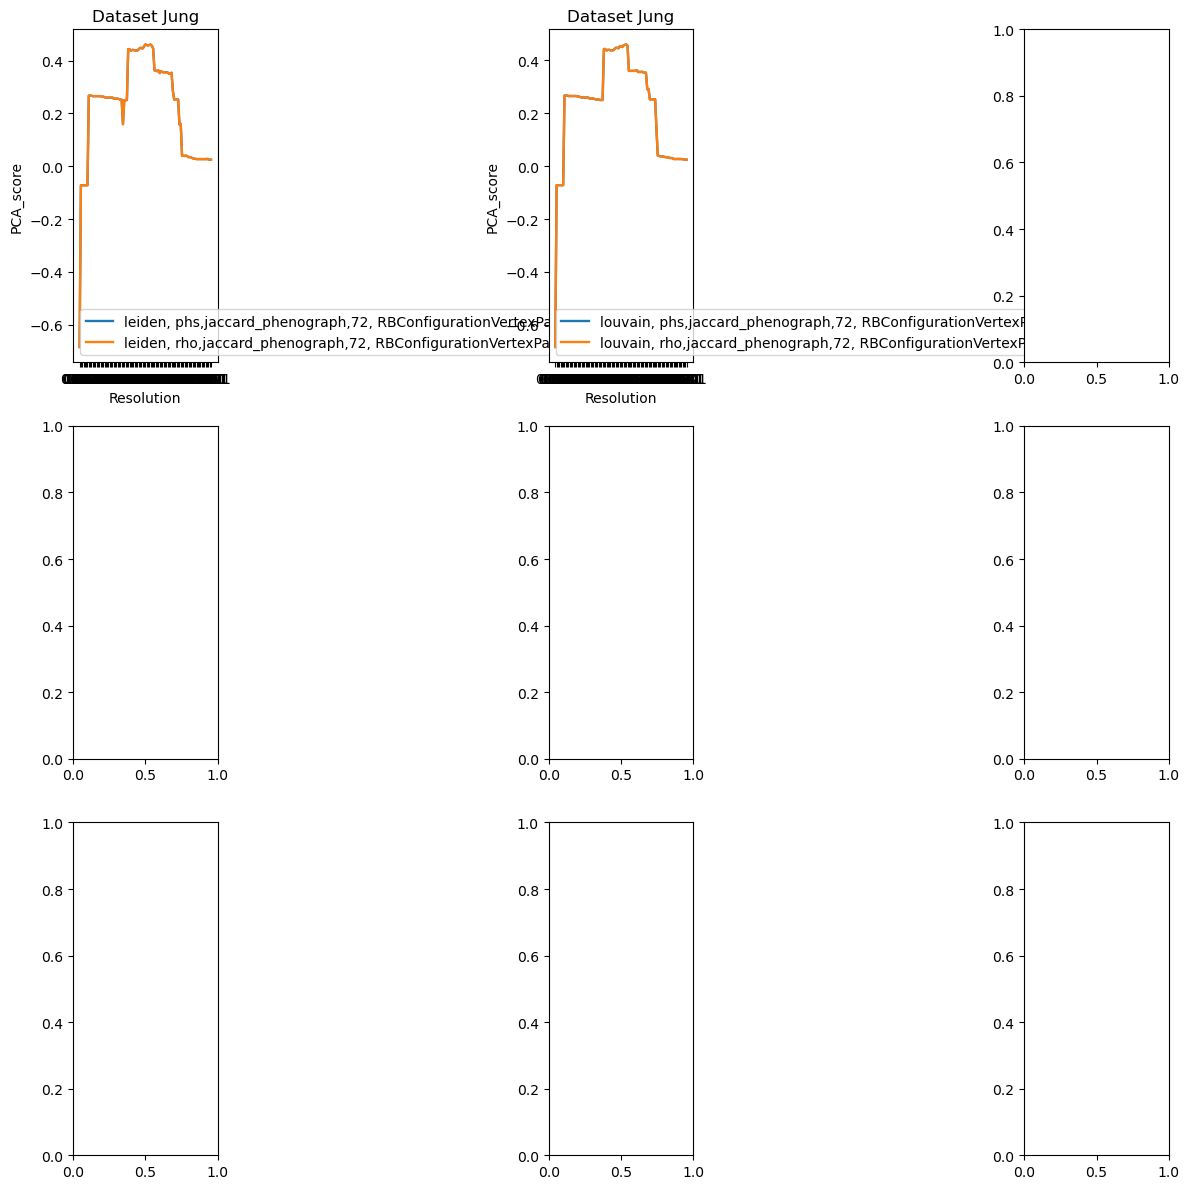

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
checks = []
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()  # Flatten for easy iteration

i = 0  # Move 'i' outside the loop

for comb in combinations_to_check:
    for idx, row in comb.iterrows():
        if i >= len(axes):  # Prevent index error if too many combinations
            break

        # Find matching rows
        matches = match_rows(row, all_results, [
            'Dataset', 'Quality_Function', 'Similarity_Measure',
            'K_Neighbors', 'Graph_type', 'Clustering_algorithm'
        ])

        checks.append(matches)
        # Plot lineplot
        sns.lineplot(x="Resolution", y=f"{METRIC}", data=matches, ax=axes[i], 
                     linewidth=1.7, label=f"{matches.Clustering_algorithm.iloc[0]}, {matches.Similarity_Measure.iloc[0]},{matches.Graph_type.iloc[0]},{matches.K_Neighbors.iloc[0]}, {matches.Quality_Function.iloc[0]}")

        axes[i].set_title(f"Dataset {matches.Dataset.iloc[0]}")  # Optional: add title
    i += 1  # Increment counter

plt.tight_layout()  # Prevent overlap
plt.show()  # Show all plots together


In [24]:
for i in range(0,len(checks),2):
    metric_match = np.all(checks[i].PCA_score.values == checks[i+1].PCA_score.values)
    print(f"Pair ({i}, {i+1}) {METRIC} Match: {metric_match}")

Pair (0, 1) PCA_score Match: True
Pair (2, 3) PCA_score Match: True


These combinations differ only by distance measure (phs/rho) and they have exactly the same PSI for each of the other hyper-parameters values. Combine distance measures into one



In [25]:
datasets_ties_resolved_final = datasets_ties_resolved.groupby(['Dataset', 'Clustering_algorithm']).agg(lambda x: '/'.join(sorted(x.astype(str).unique()))).reset_index()

In [26]:
datasets_ties_resolved_final

,Dataset,Clustering_algorithm,Quality_Function,Similarity_Measure,K_Neighbors,Graph_type,PSI,ARI,NMI,PCA_score,Max_across_resolution_values,Resolution,Mean_PCA_score
0,BaronPancreasData,leiden,RBERVertexPartition,spearman,15,gauss,0.0308267873728446,0.7979667268989789,0.6513552422206754,0.1940655653729404,1,0.021,-0.219806803450653
1,BaronPancreasData,louvain,RBERVertexPartition,spearman,15,gauss,0.0308267873728446,0.7979667268989789,0.6513552422206754,0.1940655653729404,1,0.021,-0.21923356156961293
2,Deng,leiden,RBConfigurationVertexPartition,braycurtis,5,gauss,0.7064551524732705,0.8825671766104964,0.9054339293825516,0.7404310978812271,16,0.201,0.34316539398928325
3,Jung,leiden,RBConfigurationVertexPartition,phs/rho,72,jaccard_phenograph,0.7412996646186953,0.627103013401122,0.6498537914563454,0.461209009560817,1,1.001,0.2264028687623156
4,Jung,louvain,RBConfigurationVertexPartition,phs/rho,72,jaccard_phenograph,0.7405284918783398,0.6266144051831336,0.6503687772375663,0.4606959282439599,1,1.081,0.22667744494658332
5,Koh,leiden,CPMVertexPartition,phs,32,gauss,0.9785361310761136,0.9685981366064834,0.971296595911182,0.9791346044292112,1,0.241,-0.07554727252241641
6,Kolodziejczyk,leiden,RBERVertexPartition,cosine,92,jaccard_phenograph,0.4473059341975783,0.7710295617117277,0.781894261154048,0.46372630495053935,4,0.421,0.10257338861920719
7,ZeiselBrainData,leiden,RBConfigurationVertexPartition,rho,28,gauss,0.1083070375279856,0.795984391094845,0.6806666898204569,0.24871467577719222,1,0.041,-0.041371130925076806
8,Zheng,louvain,RBConfigurationVertexPartition,euclidean,4,gauss,0.2893909306230354,0.9586712444182138,0.8548049199402616,0.5424146954114001,1,0.021,-0.1637171738202187


Combine ties dataframe, with no ties dataframe

In [27]:
best_comb_final = pd.concat([datasets_no_ties, datasets_ties_resolved_final], ignore_index=True).sort_values(by='Dataset').reset_index(drop=True)

In [28]:
best_comb_final

,Dataset,Clustering_algorithm,Quality_Function,Similarity_Measure,K_Neighbors,Graph_type,PSI,ARI,NMI,PCA_score,Max_across_resolution_values,Resolution,Mean_PCA_score
0,BaronPancreasData,leiden,RBERVertexPartition,spearman,15,gauss,0.0308267873728446,0.7979667268989789,0.6513552422206754,0.1940655653729404,1,0.021,-0.219806803450653
1,BaronPancreasData,louvain,RBERVertexPartition,spearman,15,gauss,0.0308267873728446,0.7979667268989789,0.6513552422206754,0.1940655653729404,1,0.021,-0.21923356156961293
2,Biase,leiden,RBERVertexPartition,phs,14,gauss,1.0,1.0,1.0,1.026164,81,1.161,NaN
3,Biase,louvain,RBERVertexPartition,phs,14,gauss,1.0,1.0,1.0,1.026164,81,1.161,NaN
4,DarmanisBrainData,louvain,RBERVertexPartition,spearman,7,jaccard_seurat,0.36089,0.252043,0.510524,-0.071356,1,0.361,NaN
5,DarmanisBrainData,leiden,RBERVertexPartition,spearman,6,jaccard_seurat,0.359857,0.249719,0.503346,-0.076933,5,0.261,NaN
6,Deng,louvain,RBERVertexPartition,braycurtis,5,umap,0.706455,0.882567,0.905434,0.740431,19,0.201,NaN
7,Deng,leiden,RBConfigurationVertexPartition,braycurtis,5,gauss,0.7064551524732705,0.8825671766104964,0.9054339293825516,0.7404310978812271,16,0.201,0.34316539398928325
8,Goolam,leiden,RBERVertexPartition,euclidean,64,jaccard_phenograph,0.489045,0.89188,0.876055,0.61477,17,1.141,NaN
9,Goolam,louvain,RBERVertexPartition,euclidean,64,jaccard_phenograph,0.489045,0.89188,0.876055,0.61477,17,1.141,NaN


In [31]:
best_comb_final.to_pickle("../results_analysis/best_combinations_processed_PCA.pkl")
best_comb_final.to_csv("../results_analysis/best_combinations_processed_PCA.csv")